In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import seaborn as sns

from matplotlib import pyplot as plt
from hdbscan import HDBSCAN 

In [2]:
### Faster
time_resolution = 30
time_window = 5

In [3]:
df_tech_overlaps = pd.read_csv("../result_csv/tech_overlaps_smoothed"+str(time_resolution+time_window)+".csv")
df_social_overlaps = pd.read_csv("../result_csv/social_overlaps_smoothed"+str(time_resolution+time_window)+".csv")
df_tech_edgesize = pd.read_csv("../result_csv/tech_edgesize_smoothed"+str(time_resolution+time_window)+".csv")
df_social_edgesize = pd.read_csv("../result_csv/social_edgesize_smoothed"+str(time_resolution+time_window)+".csv")

all_graduated = np.load('../all_graduated.npy').tolist()
#all_graduated = [x.lower() for x in all_graduated]
all_retired = np.load('../all_retired.npy').tolist()
#all_retired = [x.lower() for x in all_retired]

all_graduated = [x.lower() for x in all_graduated if x.lower() in df_tech_overlaps.columns and x.lower() in df_social_overlaps.columns]
all_retired = [x.lower() for x in all_retired if x.lower() in df_tech_overlaps.columns and x.lower() in df_social_overlaps.columns]

In [4]:
sustain_label_tech = []
for proj in df_tech_edgesize.columns :
    if proj.lower() in all_graduated:
        sustain_label_tech.append(100)
        continue
    elif proj.lower() in all_retired:
        sustain_label_tech.append(0)
        continue
    else:
        sustain_label_tech.append(-1)

sustain_label_social = []
for proj in df_social_edgesize.columns :
    if proj.lower() in all_graduated:
        sustain_label_social.append(100)
        continue
    elif proj.lower() in all_retired:
        sustain_label_social.append(0)
        continue
    else:
        sustain_label_social.append(-1)


In [5]:
pd.Series(sustain_label_tech).value_counts()

 100    189
 0       50
-1       19
dtype: int64

In [6]:
pd.Series(sustain_label_social).value_counts()

 100    189
 0       50
-1       33
dtype: int64

In [7]:
t = pd.DataFrame(sustain_label_tech).T
t.columns = df_tech_edgesize.columns
t.append(df_tech_edgesize, ignore_index=True).reset_index(drop=True)

/tmp/ipykernel_20054/2266264582.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  t.append(df_tech_edgesize, ignore_index=True).reset_index(drop=True)


,openwebbeans,jena,shindig,sanselan,skywalking,stdcxx,wave,tajo,ratis,mrunit,...,juice,muse,chemistry,beehive,reef,cayenne,ofbiz,zipkin,subversion,cmda
0,100,100,100,100,100,100,0,100,100,100,...,0,100,100,100,100,100,100,0,100,-1
1,145,18,133,7,1019,9,28,674,667,30,...,9,10,133,632,1131,375,754,1,505,459
2,393,5,227,206,430,55,16,284,254,5,...,-1,159,94,305,121,144,228,40,345,808
3,199,17,308,101,1277,47,2,566,80,1,...,-1,26,135,880,2011,612,1135,41,-1,-1
4,129,208,243,26,1191,80,2,316,76,5,...,-1,634,51,419,698,470,213,32,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
96,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
97,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
98,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [8]:
df_tech_edgesize_groups = t.append(df_tech_edgesize, ignore_index=True).reset_index(drop=True).T

/tmp/ipykernel_20054/848246505.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tech_edgesize_groups = t.append(df_tech_edgesize, ignore_index=True).reset_index(drop=True).T


In [9]:
df_tech_edgesize_groups

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
openwebbeans,100,145,393,199,129,183,188,247,200,259,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
jena,100,18,5,17,208,258,288,306,975,648,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
shindig,100,133,227,308,243,559,666,811,675,377,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
sanselan,100,7,206,101,26,12,9,1,17,91,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
skywalking,100,1019,430,1277,1191,456,933,465,2218,470,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cayenne,100,375,144,612,470,390,111,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
ofbiz,100,754,228,1135,213,342,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
zipkin,0,1,40,41,32,27,1340,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
subversion,100,505,345,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [10]:
df_tech_edgesize_graduated = df_tech_edgesize_groups.where(df_tech_edgesize_groups[0]==100).dropna()[range(1,99)]

In [11]:
df_tech_edgesize_graduated

,1,2,3,4,5,6,7,8,9,10,...,89,90,91,92,93,94,95,96,97,98
openwebbeans,145.0,393.0,199.0,129.0,183.0,188.0,247.0,200.0,259.0,270.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
jena,18.0,5.0,17.0,208.0,258.0,288.0,306.0,975.0,648.0,296.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
shindig,133.0,227.0,308.0,243.0,559.0,666.0,811.0,675.0,377.0,348.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
sanselan,7.0,206.0,101.0,26.0,12.0,9.0,1.0,17.0,91.0,15.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
skywalking,1019.0,430.0,1277.0,1191.0,456.0,933.0,465.0,2218.0,470.0,940.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
beehive,632.0,305.0,880.0,419.0,214.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
reef,1131.0,121.0,2011.0,698.0,267.0,386.0,1499.0,1198.0,494.0,439.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
cayenne,375.0,144.0,612.0,470.0,390.0,111.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
ofbiz,754.0,228.0,1135.0,213.0,342.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [12]:
df_tech_edgesize_retired = df_tech_edgesize_groups.where(df_tech_edgesize_groups[0]==0).dropna()[range(1,99)]

In [13]:
df_tech_edgesize_retired.head()

,1,2,3,4,5,6,7,8,9,10,...,89,90,91,92,93,94,95,96,97,98
wave,28.0,16.0,2.0,2.0,1.0,17.0,7.0,24.0,26.0,31.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
awf,105.0,24.0,10.0,109.0,107.0,6.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
tamaya,734.0,380.0,285.0,144.0,245.0,81.0,94.0,152.0,232.0,179.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
tashi,44.0,2.0,19.0,35.0,11.0,19.0,29.0,23.0,20.0,6.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
myriad,573.0,223.0,7.0,18.0,12.0,3.0,31.0,25.0,65.0,104.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [14]:
t = pd.DataFrame(sustain_label_social).T
t.columns = df_social_edgesize.columns
t.append(df_social_edgesize, ignore_index=True).reset_index(drop=True)

/tmp/ipykernel_20054/924396843.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  t.append(df_social_edgesize, ignore_index=True).reset_index(drop=True)


,openwebbeans,jena,etch,shindig,sanselan,rya,skywalking,stdcxx,wave,tajo,...,sqoop,myfaces,nutch,muse,chemistry,reef,ofbiz,tapestry,subversion,kabuki
0,100,100,100,100,100,100,100,100,0,100,...,100,100,100,100,100,100,100,-1,100,-1
1,10,142,14,156,28,40,6,12,496,84,...,30,1506,0,18,52,36,0,222,542,10
2,26,116,34,306,28,72,4,32,468,30,...,58,1442,370,6,40,62,102,-1,1098,-1
3,34,148,36,440,14,58,48,8,484,54,...,44,1598,402,2,10,30,692,-1,-1,-1
4,24,126,52,600,6,28,16,6,356,20,...,54,1866,266,2,8,46,520,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
96,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
97,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
98,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [15]:
df_social_edgesize_groups = t.append(df_social_edgesize, ignore_index=True).reset_index(drop=True).T

/tmp/ipykernel_20054/1253798103.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_social_edgesize_groups = t.append(df_social_edgesize, ignore_index=True).reset_index(drop=True).T


In [16]:
df_social_edgesize_graduated = df_social_edgesize_groups.where(df_tech_edgesize_groups[0]==100).dropna()[range(1,99)]
df_social_edgesize_graduated

,1,2,3,4,5,6,7,8,9,10,...,89,90,91,92,93,94,95,96,97,98
openwebbeans,10.0,26.0,34.0,24.0,28.0,22.0,8.0,14.0,46.0,46.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
jena,142.0,116.0,148.0,126.0,156.0,120.0,112.0,166.0,250.0,284.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
etch,14.0,34.0,36.0,52.0,38.0,38.0,18.0,24.0,10.0,2.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
shindig,156.0,306.0,440.0,600.0,482.0,636.0,464.0,332.0,370.0,278.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
sanselan,28.0,28.0,14.0,6.0,2.0,18.0,24.0,6.0,14.0,34.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
muse,18.0,6.0,2.0,2.0,8.0,14.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
chemistry,52.0,40.0,10.0,8.0,8.0,34.0,102.0,96.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
reef,36.0,62.0,30.0,46.0,38.0,12.0,46.0,54.0,68.0,134.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
ofbiz,0.0,102.0,692.0,520.0,452.0,420.0,550.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [17]:
df_social_edgesize_retired = df_social_edgesize_groups.where(df_tech_edgesize_groups[0]==0).dropna()[range(1,99)]
df_social_edgesize_retired.shape

(50, 98)

In [18]:
vectors_tech_edgesize_graduated = df_tech_edgesize_graduated[range(1,24)].replace(-1.0,0.0).values
vectors_tech_edgesize_retired = df_tech_edgesize_retired[range(1,24)].replace(-1.0,0.0).values
vectors_social_edgesize_retired = df_social_edgesize_retired[range(1,24)].replace(-1.0,0.0).values
vectors_social_edgesize_graduated = df_social_edgesize_graduated[range(1,24)].replace(-1.0,0.0).values

<AxesSubplot:>

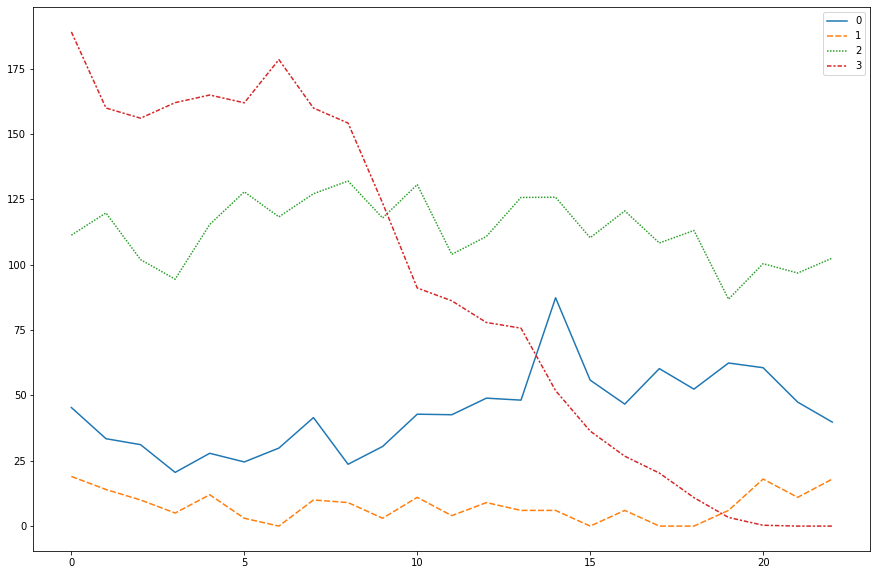

In [19]:
social_graduated_clusterer = HDBSCAN(algorithm= 'best', approx_min_span_tree=True, gen_min_span_tree=True, metric='canberra',  min_cluster_size= 2).fit(vectors_social_edgesize_graduated)
df_labels_mean = pd.DataFrame(np.c_[vectors_social_edgesize_graduated, social_graduated_clusterer.labels_]).groupby(23).agg('mean')
plt.figure(figsize=(15, 10))
sns.lineplot(data= df_labels_mean.values.T)

<AxesSubplot:>

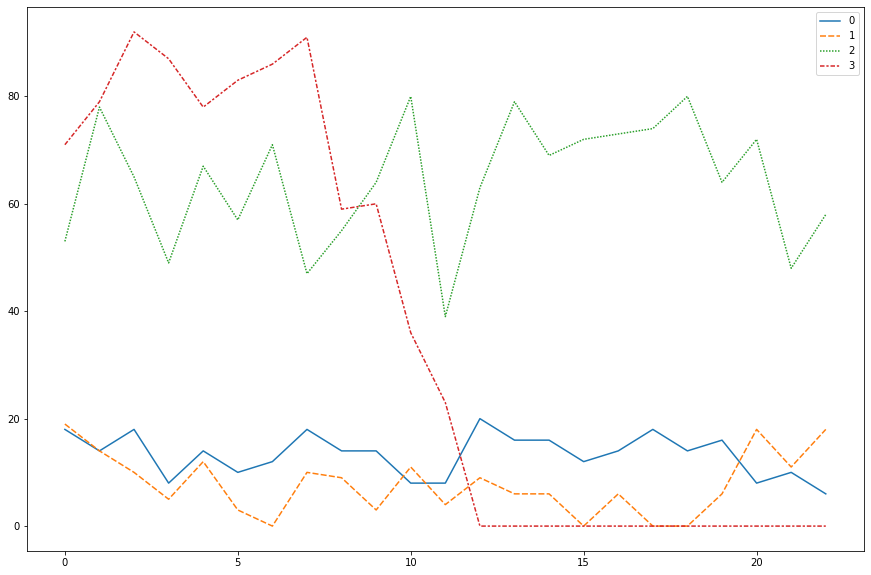

In [20]:
social_graduated_clusterer = HDBSCAN(algorithm= 'best', approx_min_span_tree=True, gen_min_span_tree=True, metric='canberra',  min_cluster_size= 2).fit(vectors_social_edgesize_graduated)
df_labels_median = pd.DataFrame(np.c_[vectors_social_edgesize_graduated, social_graduated_clusterer.labels_]).groupby(23).agg('median')
plt.figure(figsize=(15, 10))
sns.lineplot(data= df_labels_median.values.T)

In [21]:
pd.value_counts(social_graduated_clusterer.labels_)

 2    130
-1     29
 1     28
 0      2
dtype: int64

In [25]:
temp_labels_mean = df_labels_mean.T
temp_labels_mean.columns=['outliers_mean', 'c1_mean', 'c2_mean', 'c3_mean']
temp_labels_mean.loc[23]=[-1,0,1,2]

In [73]:
df_social_edgesize_graduated_labeled = pd.DataFrame(np.c_[vectors_social_edgesize_graduated, social_graduated_clusterer.labels_]).T
df_social_edgesize_graduated_labeled.columns = df_social_edgesize_graduated.T.columns
df_social_edgesize_graduated_labeled = pd.concat([df_social_edgesize_graduated_labeled.T, temp_labels_mean.T], axis=0)
#df_social_edgesize_graduated_labeled['time'] = df_social_edgesize_graduated_labeled.index
df_social_edgesize_graduated_labeled

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
openwebbeans,10.000000,26.000000,34.000000,24.000000,28.000000,22.000000,8.000000,14.000000,46.000000,46.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0
jena,142.000000,116.000000,148.000000,126.000000,156.000000,120.000000,112.000000,166.000000,250.000000,284.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0
etch,14.000000,34.000000,36.000000,52.000000,38.000000,38.000000,18.000000,24.000000,10.000000,2.000000,...,8.000000,2.000000,10.000000,8.000000,4.000000,18.000000,36.000000,20.000000,18.000000,-1.0
shindig,156.000000,306.000000,440.000000,600.000000,482.000000,636.000000,464.000000,332.000000,370.000000,278.000000,...,676.000000,272.000000,266.000000,162.000000,170.000000,126.000000,144.000000,206.000000,0.000000,1.0
sanselan,28.000000,28.000000,14.000000,6.000000,2.000000,18.000000,24.000000,6.000000,14.000000,34.000000,...,18.000000,6.000000,36.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
subversion,542.000000,1098.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0
outliers_mean,45.379310,33.448276,31.172414,20.551724,27.862069,24.551724,29.862069,41.517241,23.655172,30.482759,...,87.379310,55.862069,46.689655,60.275862,52.413793,62.413793,60.620690,47.448276,39.793103,-1.0
c1_mean,19.000000,14.000000,10.000000,5.000000,12.000000,3.000000,0.000000,10.000000,9.000000,3.000000,...,6.000000,0.000000,6.000000,0.000000,0.000000,6.000000,18.000000,11.000000,18.000000,0.0
c2_mean,111.357143,119.857143,102.000000,94.500000,115.428571,127.928571,118.357143,127.214286,132.071429,117.928571,...,125.857143,110.357143,120.642857,108.357143,113.142857,86.857143,100.428571,96.857143,102.571429,1.0


In [83]:
this_group= df_social_edgesize_graduated_labeled.groupby(23).get_group(-1.0)

<Figure size 1080x720 with 0 Axes>

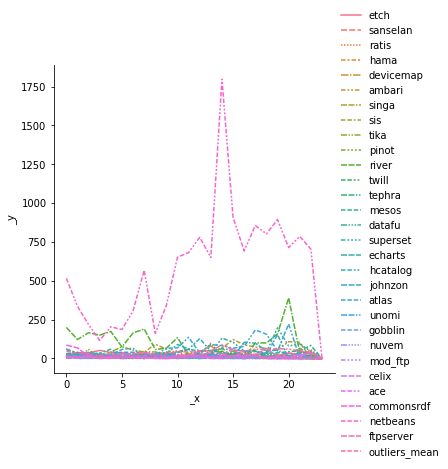

In [82]:
plt.figure(figsize=(15, 10))
sns.relplot(data=df_social_edgesize_graduated_labeled.groupby(23).get_group(-1.0).T, kind='line')

<AxesSubplot:>

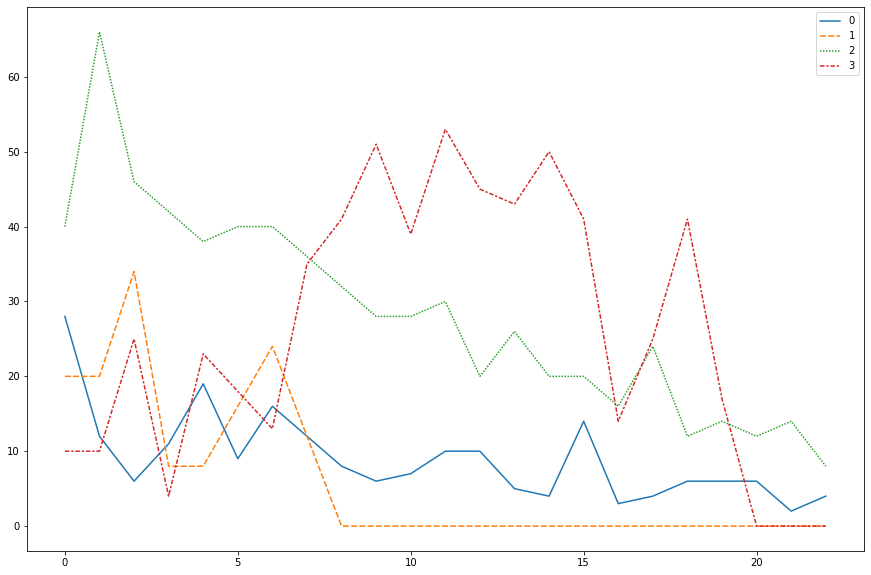

In [ ]:
social_retired_clusterer = HDBSCAN(algorithm= 'best', approx_min_span_tree=True, gen_min_span_tree=True, metric='canberra',  min_cluster_size= 2).fit(vectors_social_edgesize_retired)
df_labels_median = pd.DataFrame(np.c_[vectors_social_edgesize_retired, social_retired_clusterer.labels_]).groupby(23).agg('median')
plt.figure(figsize=(15, 10))
sns.lineplot(data= df_labels_median.values.T)

In [ ]:
pd.value_counts(social_retired_clusterer.labels_)

-1    18
 1    17
 0    13
 2     2
dtype: int64

<AxesSubplot:>

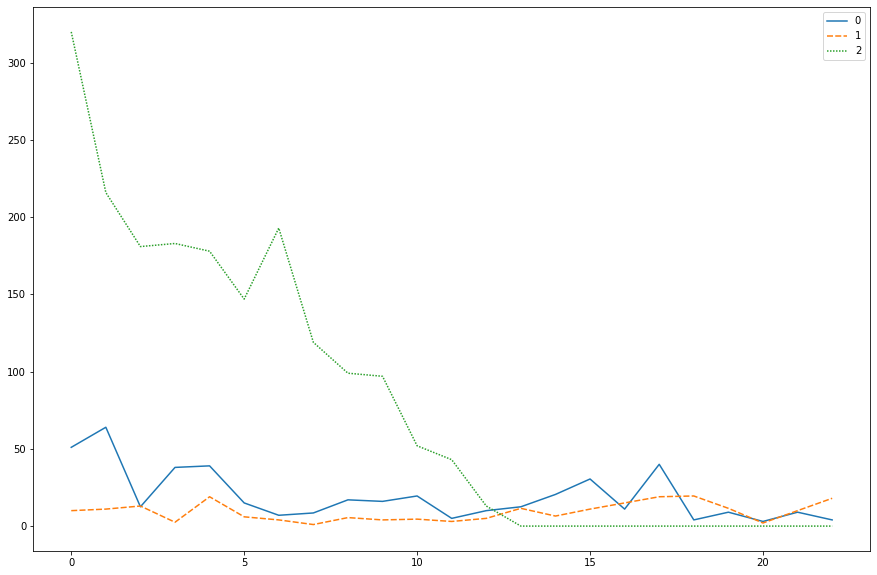

In [ ]:
tech_graduated_clusterer = HDBSCAN(algorithm= 'best', approx_min_span_tree=True, gen_min_span_tree=True, metric='canberra',  min_cluster_size= 2).fit(vectors_tech_edgesize_graduated)
df_labels_median = pd.DataFrame(np.c_[vectors_tech_edgesize_graduated, tech_graduated_clusterer.labels_]).groupby(23).agg('median')
plt.figure(figsize=(15, 10))
sns.lineplot(data= df_labels_median.values.T)

In [ ]:
pd.value_counts(tech_graduated_clusterer.labels_)

 1    175
-1     10
 0      4
dtype: int64

<AxesSubplot:>

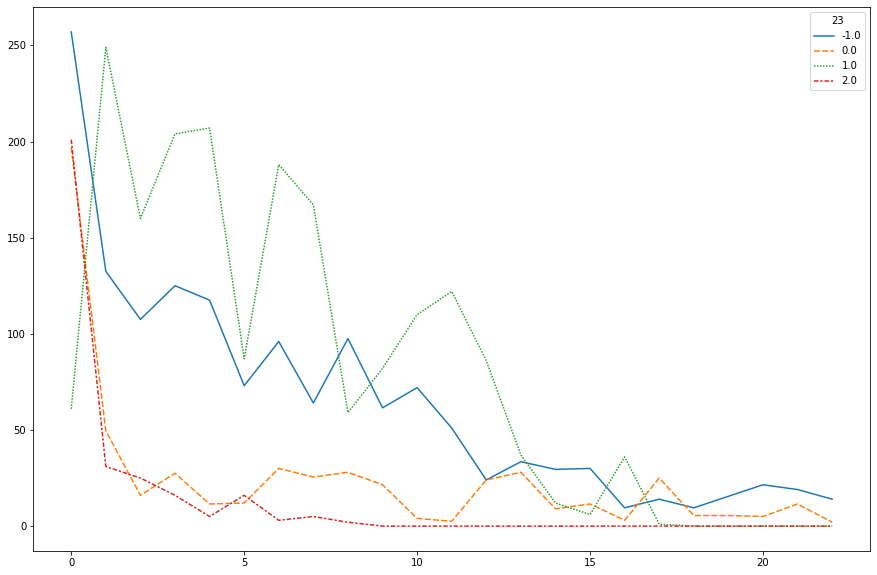

In [ ]:
tech_retired_clusterer = HDBSCAN(algorithm= 'best', approx_min_span_tree=True, gen_min_span_tree=True, metric='canberra',  min_cluster_size= 2).fit(vectors_tech_edgesize_retired)
df_labels_median = pd.DataFrame(np.c_[vectors_tech_edgesize_retired, tech_retired_clusterer.labels_]).groupby(23).agg('median')
plt.figure(figsize=(15, 10))
sns.lineplot(data= df_labels_median.T)

In [ ]:
df_labels_median.reset_index(drop=True).T

,0,1,2,3
0,257.0,197.0,61.0,201.0
1,132.5,49.5,249.0,31.0
2,107.5,16.0,160.0,25.0
3,125.0,27.5,204.0,16.0
4,117.5,11.5,207.0,5.0
5,73.0,12.0,87.0,16.0
6,96.0,30.0,188.0,3.0
7,64.0,25.5,167.0,5.0
8,97.5,28.0,59.0,2.0
9,61.5,21.5,82.0,0.0


In [ ]:
pd.value_counts(tech_retired_clusterer.labels_)

 2    21
-1    20
 0     6
 1     3
dtype: int64